In [1]:
from bbq.decoder import d_osd, bp_osd, belief_propagation, _syn_inv_permute_field
from bbq.utils import det_to_err, err_to_det, find_pivots, rref
import numpy as np
from ldpc import BpDecoder, bposd_decoder
from bbq.polynomial import Polynomial
from bbq.bbq_code import BivariateBicycle
import matplotlib.pyplot as plt
import json
import datetime
import galois

## Qudits!

In [10]:
p = 0.01
field = 3
a = Polynomial(3, np.array([[1, 0], [-1, 0]]))
b = Polynomial(3, np.array([[1, -1], [0, 0]]))
bb3 = BivariateBicycle(a, b, 3, 3, 1)
h = bb3.hx
l = bb3.x_logicals
max_iter = 100

for it in range(50):
    # Generate syndrome
    n_qudits = h.shape[1]
    error = np.zeros(n_qudits, dtype=int)
    error_mask = np.random.rand(n_qudits) < p
    for i in np.where(error_mask)[0]:
        error[i] = np.random.randint(1, field)
    syndrome = (h @ error) % field

    # Construct error probability
    channel_prob_x = np.ones(n_qudits) * p

    x_prior = np.zeros((len(channel_prob_x), field), dtype=float)

    for i, prob in enumerate(channel_prob_x):
        x_prior[i, 0] = 1 - prob
        for j in range(1, field):
            x_prior[i, j] = prob / (field - 1)

    # Decode
    # guessed_error, decoder_success, bp_success, posterior = belief_propagation(field, h, syndrome, x_prior, max_iter, debug=True)
    guessed_error, decoder_success, bp_success, posterior = bp_osd(field, h, syndrome, x_prior, max_iter, order=0, debug=True)
    error_difference = (error - guessed_error) % field
    logical_effect = (np.array(l) @ error_difference) % field

In [2]:
def simulate(field, h, l, max_iter, num_failures, physical_error):

    results = []

    for p in physical_error:

        failures = 0
        num_trials = 0

        while failures < num_failures:
            # Generate syndrome
            n_qudits = h.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, field)
            syndrome = (h @ error) % field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), field), dtype=float)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, field):
                    x_prior[i, j] = prob / (field - 1)

            # Decode
            # guessed_error, decoder_success, bp_success, posterior = belief_propagation(field, h, syndrome, x_prior, max_iter, debug=True)
            guessed_error, decoder_success, bp_success, posterior = bp_osd(field, h, syndrome, x_prior, max_iter, order=0, debug=True)
            error_difference = (error - guessed_error) % field
            logical_effect = (np.array(l) @ error_difference) % field

            # Check success
            # if np.any(logical_effect != 0) or not decoder_success:
            if np.any(logical_effect != 0):
                failures += 1
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')
            elif num_trials % 100 == 0:
                print(f'UPDATE: Found {failures} / {num_failures}, with num_trials : {num_trials}')

            num_trials += 1

        results.append(num_trials)

        print(f'Finished p={p} with num_trials={num_trials}')
        print('------------------------------------------------------------------')
    return results

In [3]:
a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))
bb2 = BivariateBicycle(a, b, 3, 3, 1)
h2 = bb2.hx
l2 = bb2.x_logicals
bb25 = BivariateBicycle(a, b, 5, 5, 1)
h25 = bb25.hx
l25 = bb25.x_logicals
bb27 = BivariateBicycle(a, b, 7, 7, 1)
h27 = bb27.hx
l27 = bb27.x_logicals

a = Polynomial(3, np.array([[1, 0], [-1, 0]]))
b = Polynomial(3, np.array([[1, -1], [0, 0]]))
bb3 = BivariateBicycle(a, b, 3, 3, 1)
h3 = bb3.hx
l3 = bb3.x_logicals
bb35 = BivariateBicycle(a, b, 5, 5, 1)
h35 = bb35.hx
l35 = bb35.x_logicals
bb37 = BivariateBicycle(a, b, 7, 7, 1)
h37 = bb37.hx
l37 = bb37.x_logicals

a = Polynomial(5, np.array([[1, 0], [-1, 0]]))
b = Polynomial(5, np.array([[1, -1], [0, 0]]))
bb5 = BivariateBicycle(a, b, 3, 3, 1)
h5 = bb5.hx
l5 = bb5.x_logicals
bb55 = BivariateBicycle(a, b, 5, 5, 1)
h55 = bb55.hx
l55 = bb55.x_logicals
bb57 = BivariateBicycle(a, b, 7, 7, 1)
h57 = bb57.hx
l57 = bb57.x_logicals

max_iter = 1000
num_failures = 3
long_physical_error = np.logspace(-2.7, -1, 10)
physical_error = np.flip(np.logspace(-1.7, -0.7, 10))
ext_physical_error = np.flip(np.logspace(-1, -0.8, 10))
new_ext_physical_error = np.flip(np.logspace(-0.8, -0.64, 10)[1:7])

In [4]:
def process_results(results, num_failures):
    plot_results = {}
    plot_error_bars = {}
    for d in results:
        plot_results[d] = num_failures[d] / (np.array(results[d]))
        plot_error_bars[d] = np.sqrt((plot_results[d])*(1-plot_results[d])/results[d])
    return plot_results, plot_error_bars

C:\Users\elean\AppData\Local\Temp\ipykernel_18784\1591005615.py:5: RuntimeWarning: divide by zero encountered in divide
  plot_results[d] = num_failures[d] / (np.array(results[d]))
C:\Users\elean\AppData\Local\Temp\ipykernel_18784\1591005615.py:6: RuntimeWarning: invalid value encountered in sqrt
  plot_error_bars[d] = np.sqrt((plot_results[d])*(1-plot_results[d])/results[d])


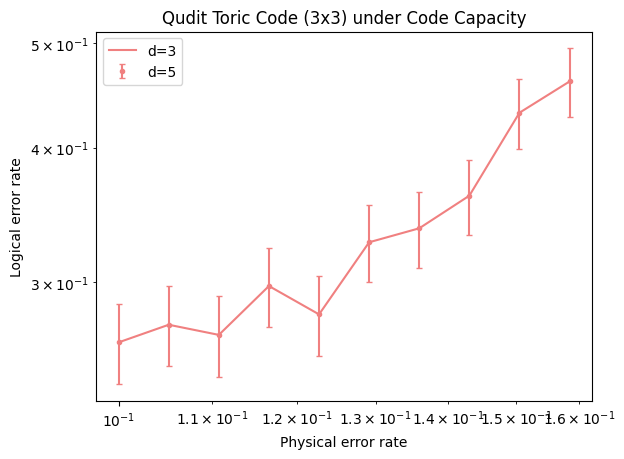

In [ ]:
results = {3: [379, 365, 373, 336, 357, 306, 297, 277, 232, 217],
           5: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           7: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
plot_num_failures = {3: 100,
                5: 0,
                7: 0}

x = np.flip(ext_physical_error)
plot_results, plot_error_bars = process_results(results, plot_num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
#plt.loglog(x, plot_results[5], color='lightseagreen')
#plt.loglog(x, plot_results[7], color='royalblue')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
#plt.errorbar(x, plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
#plt.errorbar(x, plot_results[7], yerr=plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')

plt.legend(['d=3', 'd=5', 'd=7'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Qudit Toric Code (3x3) under Code Capacity');

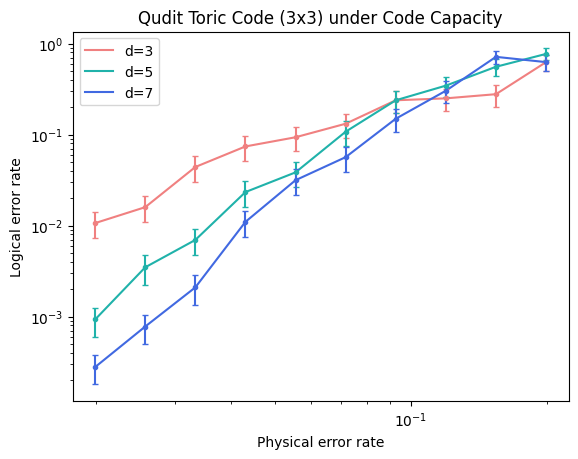

In [ ]:
results = {3: [938, 627, 227, 135, 107, 76, 42, 40, 36, 16],
           5: [8591, 2295, 1436, 428, 260, 93, 42, 29, 18, 13],
           7: [28624, 10266, 3814, 909, 317, 177, 67, 33, 14, 16]}
plot_num_failures = {3: 10,
                5: [8, 8, 10, 10, 10, 10, 10, 10, 10, 10],
                7: [8, 8, 8, 10, 10, 10, 10, 10, 10, 10]}

x = np.flip(physical_error)
plot_results, plot_error_bars = process_results(results, plot_num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x, plot_results[5], color='lightseagreen')
plt.loglog(x, plot_results[7], color='royalblue')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x, plot_results[7], yerr=plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')

plt.legend(['d=3', 'd=5', 'd=7'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Qubit Toric Code under Code Capacity');

In [ ]:
results_2 = simulate(2, h2, l2, max_iter, num_failures, physical_error)

C:\Users\elean\Documents\Quantum-Computing-PhD\ITP\IP-BBQ\qudit-bivariate-bicycle\bbq\decoder.py:105: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, error, :] = sub_convolution[syn_inv_permutation[errs[j, 1], :]]


Found 1 / 3, with num_trials : 3191
Found 2 / 3, with num_trials : 4423
Found 3 / 3, with num_trials : 9670
Finished p=0.001995262314968879 with num_trials=9671
Found 1 / 3, with num_trials : 603
Found 2 / 3, with num_trials : 837
Found 3 / 3, with num_trials : 3905
Finished p=0.0030823992397451434 with num_trials=3906
Found 1 / 3, with num_trials : 1782
Found 2 / 3, with num_trials : 2172
Found 3 / 3, with num_trials : 3283
Finished p=0.004761872663008535 with num_trials=3284
Found 1 / 3, with num_trials : 55
Found 2 / 3, with num_trials : 239
Found 3 / 3, with num_trials : 247
Finished p=0.007356422544596414 with num_trials=248
Found 1 / 3, with num_trials : 105
Found 2 / 3, with num_trials : 413
Found 3 / 3, with num_trials : 512
Finished p=0.011364636663857243 with num_trials=513
Found 1 / 3, with num_trials : 94
Found 2 / 3, with num_trials : 102
Found 3 / 3, with num_trials : 105
Finished p=0.017556762912750015 with num_trials=106
Found 1 / 3, with num_trials : 15
Found 2 / 3, wi

In [14]:
results_3 = simulate(3, h3, l3, max_iter, num_failures, physical_error)

C:\Users\elean\Documents\Quantum-Computing-PhD\ITP\IP-BBQ\qudit-bivariate-bicycle\bbq\decoder.py:105: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, error, :] = sub_convolution[syn_inv_permutation[errs[j, 1], :]]


Found 1 / 3, with num_trials : 11286
Found 2 / 3, with num_trials : 14643
Found 3 / 3, with num_trials : 15258
Finished p=0.001995262314968879 with num_trials=15259
Found 1 / 3, with num_trials : 226
Found 2 / 3, with num_trials : 5046
Found 3 / 3, with num_trials : 6713
Finished p=0.0030823992397451434 with num_trials=6714
Found 1 / 3, with num_trials : 700
Found 2 / 3, with num_trials : 1166
Found 3 / 3, with num_trials : 2288
Finished p=0.004761872663008535 with num_trials=2289
Found 1 / 3, with num_trials : 23
Found 2 / 3, with num_trials : 190
Found 3 / 3, with num_trials : 435
Finished p=0.007356422544596414 with num_trials=436
Found 1 / 3, with num_trials : 99
Found 2 / 3, with num_trials : 257
Found 3 / 3, with num_trials : 359
Finished p=0.011364636663857243 with num_trials=360
Found 1 / 3, with num_trials : 146
Found 2 / 3, with num_trials : 279
Found 3 / 3, with num_trials : 317
Finished p=0.017556762912750015 with num_trials=318
Found 1 / 3, with num_trials : 12
Found 2 / 3

In [17]:
results_5 = simulate(5, h5, l5, max_iter, num_failures, physical_error)

Found 1 / 3, with num_trials : 110
Found 2 / 3, with num_trials : 18320
Found 3 / 3, with num_trials : 20470
Finished p=0.001995262314968879 with num_trials=20471
Found 1 / 3, with num_trials : 14403
Found 2 / 3, with num_trials : 22755
Found 3 / 3, with num_trials : 24197
Finished p=0.0030823992397451434 with num_trials=24198
Found 1 / 3, with num_trials : 2702
Found 2 / 3, with num_trials : 4397
Found 3 / 3, with num_trials : 5409
Finished p=0.004761872663008535 with num_trials=5410
Found 1 / 3, with num_trials : 279
Found 2 / 3, with num_trials : 342
Found 3 / 3, with num_trials : 379
Finished p=0.007356422544596414 with num_trials=380
Found 1 / 3, with num_trials : 466
Found 2 / 3, with num_trials : 736
Found 3 / 3, with num_trials : 775
Finished p=0.011364636663857243 with num_trials=776
Found 1 / 3, with num_trials : 10
Found 2 / 3, with num_trials : 37
Found 3 / 3, with num_trials : 55
Finished p=0.017556762912750015 with num_trials=56
Found 1 / 3, with num_trials : 17
Found 2 /

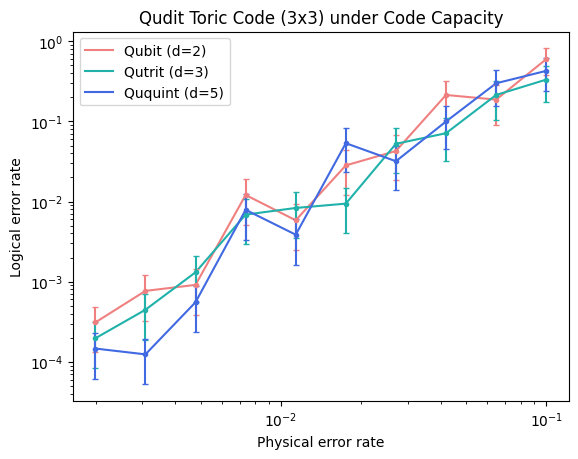

In [19]:
#results = {2 : results_2}
#results = {2 : results_2, 3 : results_3}
results = {2 : results_2, 3 : results_3, 5 : results_5}

x = np.logspace(-2.7, -1, 10)
plot_num_failures = {2 : 3, 3 : 3, 5 : 3}
plot_results, plot_error_bars = process_results(results, plot_num_failures)

plt.loglog(x, plot_results[2], color='lightcoral')
plt.loglog(x, plot_results[3], color='lightseagreen')
plt.loglog(x, plot_results[5], color='royalblue')

plt.errorbar(x, plot_results[2], yerr=plot_error_bars[2], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x, plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='royalblue')

plt.legend(['Qubit (d=2)', 'Qutrit (d=3)', 'Ququint (d=5)'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Qudit Toric Code (3x3) under Code Capacity');

## Simple examples

In [79]:
h_eff = np.array([[0, 0, 1, 1], [0, 1, 1, 1], [0, 1, 1, 0]])
prior = np.array([[0.9, 0.1], [0.9, 0.1], [0.8, 0.2], [0.8, 0.2]])

p = 0.1
field = 2
max_iter = 1000

n_dets, n_qudits = h_eff.shape
real_error = np.zeros(n_qudits, dtype=int)
rand = np.random.rand(n_qudits)
for err in range(n_qudits):
    if rand[err] < prior[err, 1]:
        real_error[err] = 1
syndrome = (h_eff @ real_error) % field

print(f'h_eff = \n {h_eff}')
print(f'prior = \n {prior}')
print(f'real_error = \n {real_error}')
print(f'syndrome = \n {syndrome}')

h_eff = 
 [[0 0 1 1]
 [0 1 1 1]
 [0 1 1 0]]
prior = 
 [[0.9 0.1]
 [0.9 0.1]
 [0.8 0.2]
 [0.8 0.2]]
real_error = 
 [0 0 1 0]
syndrome = 
 [1 1 1]


In [80]:
error, success = d_osd(field, h_eff, syndrome, prior, debug=False)

assert success
assert (error == real_error).all()

In [188]:
error, success, bp_success, posterior = bp_osd(field, h_eff, syndrome, prior, max_iter=1, debug=True)

assert success
(error == real_error).all()

np.True_

In [189]:
posterior[:, 1]

array([ 0.        ,  0.94444444, 25.61538462,  2.84615385])

In [190]:
np.log(1/posterior[:, 1])

C:\Users\elean\AppData\Local\Temp\ipykernel_39300\1214461436.py:1: RuntimeWarning: divide by zero encountered in divide
  np.log(1/posterior[:, 1])


array([        inf,  0.05715841, -3.24319313, -1.04596856])

In [191]:
error

array([0, 0, 1, 0], dtype=uint8)

In [192]:
bpd = BpDecoder(h_eff, error_channel=prior[:, 1], max_iter=1, bp_method='product_sum')
error = bpd.decode(syndrome)

(error == real_error).all()

np.False_

In [193]:
bpd.log_prob_ratios

array([ 2.19722458,  0.05715841, -3.24319313, -1.04596856])

In [194]:
bpd.decoding

array([0, 0, 1, 1])

In [153]:
g = bpd.log_prob_ratios
1/np.exp(g)

array([ 0.11111111,  0.94444444, 25.61538462,  2.84615385])

## Threshold graphs for Joschka's code

In [ ]:
# Code capacity model for qubit Toric code with varying distance using ldpc package

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))

num_failures = 5
max_iter = 1000
ldpc_results = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

for d in [5, 7]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lx = bb.x_logicals
    n_qudits = bb.hx.shape[1]
    # res = results_cap_qubit[d]
    res = []
    for ind, p in enumerate(np.logspace(-1.7, -0.7, 10)):
    # for p in [0.01]:
        failures = 0
        num_trials = 0
        #if d == 5:
        #    if p < 0.002:
        #        res.append(np.inf)
        #        continue
        #if d == 7:
        #    if p < 0.003:
        #        res.append(np.inf)
        #        continue
        #if d == 9:
        #    if p < 0.004:
        #        res.append(np.inf)
        #        continue

        # Construct error probability
        channel_prob_x = np.ones(n_qudits) * p  # more complicated for qudits!!!

        x_prior = np.zeros((n_qudits, bb.field), dtype=float)

        for i, prob in enumerate(channel_prob_x):
            x_prior[i, 0] = 1 - prob
            for j in range(1, bb.field):
                x_prior[i, j] = prob / (bb.field - 1)

        while failures < num_failures:
            # Generate syndrome
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Decode
            bp_osd_d = bposd_decoder(bb.hx, channel_probs=x_prior[:, 1], max_iter=max_iter, bp_method='product_sum', osd_order=0)
            guessed_error = bp_osd_d.decode(syndrome)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lx) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                # print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')

            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
        
            num_trials += 1
        # res[1+ind] = num_trials
        res.append(num_trials)
        print(f'Finished p={p} for d={d} with num_trials={num_trials}')
    print(f'Completed d={d}')
    ldpc_results[d] = res

In [15]:
jos_results = {5: [4039, 1692, 489, 204, 107, 33, 32, 22, 13, 8],
 7: [23580, 8294, 1478, 558, 145, 137, 23, 19, 7, 12],
 3: [416, 385, 213, 105, 112, 36, 22, 25, 7, 10]}

## Threshold graphs for my code

In [5]:
# Code capacity model for qubit Toric code with varying distance

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))

num_failures = 5
max_iter = 1000
night_results = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

night_debug = {}

for d in [7]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lx = bb.x_logicals
    # res = results[d]
    res = []
    night_debug[d] = {}

    for ind, p in enumerate(np.flip(np.logspace(-1.7, -0.7, 10)[0:2])):

        night_debug[d][p] = {}

        bp_errors = 0
        osd_errors = 0

        bp_successes = 0
        osd_success = 0

        # failed_osd_posteriors = []
        # failed_syndromes = []

        failures = 0
        num_trials = 0

        if d==7 and ind==0:
            failures = 4
            num_trials = 4059

        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), 2), dtype=float)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, 2):
                    x_prior[i, j] = prob / (2 - 1)

            # Decode
            guessed_error, decoder_success, bp_success, posterior = bp_osd(bb.field, bb.hx, syndrome, x_prior, max_iter, order=0, debug=True)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lx) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                if bp_success:
                    bp_errors += 1
                else:
                    osd_errors += 1
                    #failed_osd_posteriors.append(posterior)
                    #failed_syndromes.append(syndrome)
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')
            else:
                if bp_success:
                    bp_successes += 1
                else:
                    osd_success += 1

            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)

            num_trials += 1

        night_debug[d][p]['bp_errors'] = bp_errors
        night_debug[d][p]['osd_errors'] = osd_errors
        night_debug[d][p]['bp_success'] = bp_successes
        night_debug[d][p]['osd_success'] = osd_success
        #night_debug[d][p]['failed_osd_posteriors'] = failed_osd_posteriors
        #night_debug[d][p]['failed_syndromes'] = failed_syndromes

        res.append(num_trials)

        print(f'Finished p={p} for d={d} with num_trials={num_trials}')

    print(f'Completed d={d}')
    night_results[d] = res

C:\Users\elean\Documents\Quantum-Computing-PhD\ITP\IP-BBQ\qudit-bivariate-bicycle\bbq\decoder.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, error, k] = sub_convolution[(syndrome[i] - k) % field]


Found 5 / 5, with num_trials : 5182
Finished p=0.025769803745148787 for d=7 with num_trials=5183
Found 1 / 5, with num_trials : 494
Found 2 / 5, with num_trials : 4530
Found 3 / 5, with num_trials : 8425
Found 4 / 5, with num_trials : 17175
Found 5 / 5, with num_trials : 18541
Finished p=0.0199526231496888 for d=7 with num_trials=18542
Completed d=7


In [8]:
results = {3: [424, 157, 87, 53, 44, 31, 17, 16, 13, 8],
 5: [6496, 1636, 951, 330, 140, 67, 12, 19, 13, 7],
 7: [18542, 5183, 2947, 544, 110, 92, 21, 14, 6, 8]}

In [9]:
results

{3: [424, 157, 87, 53, 44, 31, 17, 16, 13, 8],
 5: [6496, 1636, 951, 330, 140, 67, 12, 19, 13, 7],
 7: [18542, 5183, 2947, 544, 110, 92, 21, 14, 6, 8]}

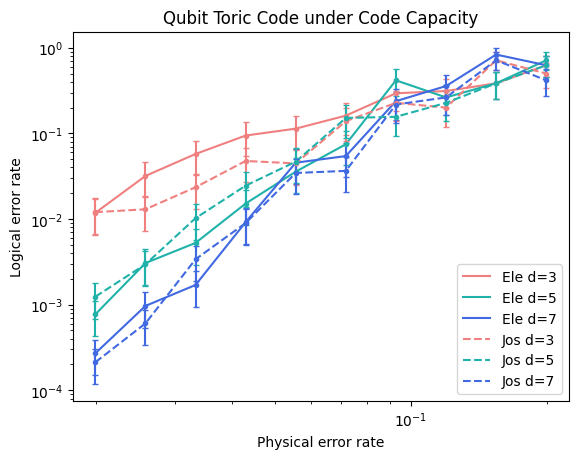

In [14]:
x = np.logspace(-1.7, -0.7, 10)
num_failures = {3 : 5, 5 : 5, 7 : 5}
plot_results, plot_error_bars = process_results(results, num_failures)
jos_plot_results, jos_plot_error_bars = process_results(jos_results, num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x, plot_results[5], color='lightseagreen')
plt.loglog(x, plot_results[7], color='royalblue')
plt.loglog(x, jos_plot_results[3], '--', color='lightcoral')
plt.loglog(x, jos_plot_results[5], '--', color='lightseagreen')
plt.loglog(x, jos_plot_results[7], '--', color='royalblue')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x, plot_results[7], yerr=plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')
plt.errorbar(x, jos_plot_results[3], yerr=jos_plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, jos_plot_results[5], yerr=jos_plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x, jos_plot_results[7], yerr=jos_plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')

plt.legend(['Ele d=3', 'Ele d=5', 'Ele d=7', 'Jos d=3', 'Jos d=5', 'Jos d=7'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Qubit Toric Code under Code Capacity');